# Docking Control Design

In [1]:
import sys
import casadi as ca
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
sys.path.insert(0, '../python/pyecca')
import pyecca.lie.so3 as so3
from pyecca.util import rk4
np.set_printoptions(suppress=True, precision=3, linewidth=200)

In [2]:
def derive_eqs():
    r_c = ca.SX.sym('r_c', 3)
    v_c = ca.SX.sym('v_c', 3)
    r_t = ca.SX.sym('r_t', 3)
    v_t = ca.SX.sym('v_t', 3)
    r_e = ca.SX.zeros(3)
    
    m_t = ca.SX.sym('m_t')
    m_c = ca.SX.sym('m_c')
    m_e = ca.SX.sym('m_e')
    
    omega = ca.SX.sym('omega')
    r0 = ca.SX.sym('r0')
    
    r_0 = ca.vertcat(r0, 0, 0)
    r_c0 = r_c + r_0
    r_t0 = r_t + r_0

    omg_vec = ca.vertcat(0, 0, omega)

    G = ca.SX.sym('G')
    F_thrust = ca.SX.sym('F_thrust', 3)

    def force_gravity(m1, r1, m2, r2):
        r = ca.norm_2(r2 - r1)
        return ca.if_else(r < 1, ca.SX.zeros(3), G*m1*m2*(r2 - r1)/r**3)

    F_c = force_gravity(m_c, r_c0, m_t, r_t0) + force_gravity(m_c, r_c0, m_e, r_e) + F_thrust
    F_t = force_gravity(m_t, r_t0, m_c, r_c0) + force_gravity(m_t, r_t0, m_e, r_e)

    # state
    x = ca.vertcat(r_c, v_c, r_t, v_t)

    # dynamics
    x_dot = ca.vertcat(
        v_c,
        F_c/m_c - 2*ca.cross(omg_vec, v_c) - ca.cross(omg_vec, ca.cross(omg_vec, r_c0)),
        v_t,
        F_t/m_t - 2*ca.cross(omg_vec, v_t) - ca.cross(omg_vec, ca.cross(omg_vec, r_t0))
    )
                                        

    # input
    u = ca.vertcat(F_thrust)
    
    # output
    y = ca.vertcat(r_c - r_t, v_c - v_t)

    # parameters
    p = ca.vertcat(m_c, m_t, m_e, G, r0, omega)

    def saturate(f, norm_max):
        n = ca.norm_2(f)
        return ca.if_else(n > norm_max, f*norm_max/n, f)
    
    # controller
    pd_control = saturate(1*(r_t - r_c) + 200*(v_t - v_c), 1) # simple PD control
    
    rhs = ca.Function('rhs', [x, u, p], [x_dot])
    measure = ca.Function('measure', [x, u, p], [y])
    control = ca.Function('control', [x, p], [pd_control])
    
    x_name = ['px_c', 'py_c', 'pz_c', 'vx_c', 'vy_c', 'vz_c', 'px_t', 'py_t', 'pz_t', 'vx_t', 'vy_t', 'vz_t']
    x_id = {name: i for i, name in enumerate(x_name)}
    
    y_name = ['px_e', 'py_e', 'pz_e', 'vx_e', 'vy_e', 'vz_e']
    y_id = {name: i for i, name in enumerate(y_name)}

    u_name = ['fx', 'fy', 'fz']
    u_id = {name: i for i, name in enumerate(u_name)}
    
    p_name = ['m_c', 'm_t', 'm_e', 'G', 'r0', 'omega']
    p_id = {name: i for i, name in enumerate(p_name)}
    
    # prediction
    dt = ca.SX.sym('dt')
    x0 = ca.SX.sym('x0', 12)
    u0 = ca.SX.sym('u0', 3)
    
    x1 = rk4(lambda t, x0: rhs(x0, u0, p), 0, x0, dt)
    predict = ca.Function('predict', [x0, u0, p, dt], [x1], ['x0', 'u0', 'p', 'dt'], ['x1'])
    
    #print(predict([0]*12, [1, 1, 1, 1, 1, 1], [1]))
    return locals()

eqs = derive_eqs()

In [3]:
def simulate(x0, dt, tf, eqs, u_vect=None):
    r_geo = 42164e3
    G = 6.67408e-11
    m_e = 5.972e24
    m_t = 419709 # iss mass
    m_c = 1000
    v_geo = np.sqrt(G*m_e/r_geo)
    omega = v_geo/r_geo

    p0 = [m_c, m_t, m_e, G, r_geo, omega]
    u0 = [0, 0, 0]
    
    # initial state: chaser: x, y, z, vx, vy, vz, target: x, y, z, vx, vy, vz
    
    t_vect = np.arange(0, tf, dt)
    
    data = {
        't': [],
        'x': [],
        'u': [],
        'y': [],
        'cost': 0
    }
    xi = x0
    for i in range(len(t_vect)):
        ti = t_vect[i]
        data['t'].append(ti)
        data['x'].append(xi)
        yi = np.array(eqs['measure'](xi, u0, p0)).reshape(-1)
        data['y'].append(yi)
        if u_vect is None:
            ui = np.array(eqs['control'](xi, p0)).reshape(-1)
        else:
            ui = np.array(u_vect[:, i]).reshape(-1)
        data['cost'] += ca.dot(ui, ui)
        data['u'].append(ui)
        
        # integrate
        res = scipy.integrate.solve_ivp(lambda t, x:np.array(eqs['rhs'](x, ui, p0)).reshape(-1), t_span=[ti, ti + dt], y0=xi, method='LSODA')
        xi = np.array(res['y'][:, -1]).reshape(-1)
        
    data['g'] = xi[:6] - xi[6:]
    data['xf'] = xi

    for k in data.keys():
        data[k] = np.array(data[k])
    return data

In [4]:
def analyze(eqs, data):
    plt.figure()
    plt.title('trajectories in shifted ECEF frame')
    plt.plot(data['x'][:, eqs['x_id']['px_t']], data['x'][:, eqs['x_id']['py_t']], 'r.-', label='target')
    plt.plot(data['x'][:, eqs['x_id']['px_c']], data['x'][:, eqs['x_id']['py_c']], 'b.-', label='chaser')
    plt.legend()
    plt.grid()
    plt.axis('equal');

    plt.figure()
    plt.title('chaser trajectory in target frame')
    plt.plot(0, 0, 'rx-', label='target')
    plt.plot(data['y'][:, eqs['y_id']['px_e']], data['y'][:, eqs['y_id']['py_e']], 'b.-', label='chaser')
    plt.legend()
    plt.grid()
    plt.axis('equal');

    plt.figure()
    plt.title('controller velocity error')
    plt.plot(data['t'], data['y'][:, eqs['y_id']['vx_e']], label='vx_e')
    plt.plot(data['t'], data['y'][:, eqs['y_id']['vy_e']], label='vy_e')
    plt.plot(data['t'], data['y'][:, eqs['y_id']['vz_e']], label='vz_e')
    plt.legend()
    plt.grid()

    plt.figure()
    plt.title('controller error')
    plt.plot(data['t'], data['y'][:, eqs['y_id']['px_e']], label='px_e')
    plt.plot(data['t'], data['y'][:, eqs['y_id']['py_e']], label='py_e')
    plt.plot(data['t'], data['y'][:, eqs['y_id']['pz_e']], label='pz_e')
    plt.legend()
    plt.grid()

    plt.figure()
    plt.title('control input')
    plt.plot(data['t'], data['u'][:, eqs['u_id']['fx']], label='fx')
    plt.plot(data['t'], data['u'][:, eqs['u_id']['fy']], label='fy')
    plt.plot(data['t'], data['u'][:, eqs['u_id']['fz']], label='fz')

    plt.legend()
    plt.grid()

# Fuel Optimal Trajectory

In [5]:
def fuel_optimal_trajectory(x0, dt, tf):
    r_geo = 42164e3
    G = 6.67408e-11
    m_e = 5.972e24
    m_t = 419709 # iss mass
    m_c = 1000
    v_geo = np.sqrt(G*m_e/r_geo)
    omega = v_geo/r_geo

    p0 = [m_c, m_t, m_e, G, r_geo, omega]
    u0 = [0, 0, 0]

    # initial state: chaser: x, y, z, vx, vy, vz, target: x, y, z, vx, vy, vz

    t_vect = np.arange(0, tf, dt)

    
    def sym_integration():
        u_vect = ca.SX.sym('u', 3, len(t_vect))
        x = x0
        for i in range(len(t_vect) - 1):
            u0 = u_vect[:, i]
            x = eqs['predict'](x, u0, p0, dt)
        xd = u_vect.reshape((len(t_vect)*3, 1))
        f = ca.dot(xd, xd)
        g = x[:6] - x[6:]
        return xd, f, g
    
    def guess_integration():
        u_pd_vect = ca.SX.zeros(3, len(t_vect))
        x = x0
        for i in range(len(t_vect) - 1):
            u0 = u_pd_vect[:, i] = eqs['control'](x, p0)
            x = eqs['predict'](x, u0, p0, dt)
        xd0 = ca.DM(u_pd_vect).reshape((len(t_vect)*3, 1))
        return xd0
    
    xd0 = guess_integration()
    xd, f, g = sym_integration()
        
    nlp = {'x':xd, 'f':f, 'g':g}
    args = {
        'print_time': 1,
        'ipopt': {
            'sb': 'yes',
            'print_level': 5,
            'max_iter': 400
            }
    }
    print('creating problem')
    S = ca.nlpsol('S', 'ipopt', nlp, args)
    print('problem created')

    n = len(t_vect)
    print('solving problem')
    res = S(x0=xd0, lbx=[-1]*n*3, ubx=[1]*n*3, lbg=[0]*6, ubg=[0]*6)
    print('problem solved')
    stats = S.stats()
    if not stats['success']:
        raise ValueError(stats['return_status'])   
    u_opt = res['x'].reshape((3, len(t_vect)))
    return u_opt

[[89.379]]


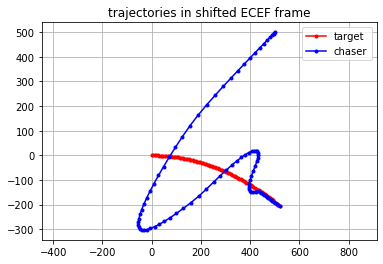

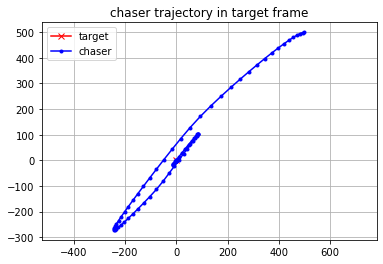

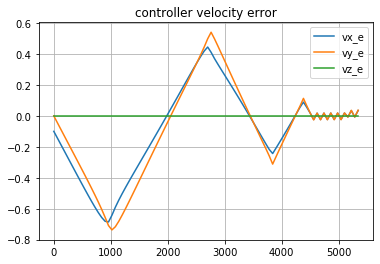

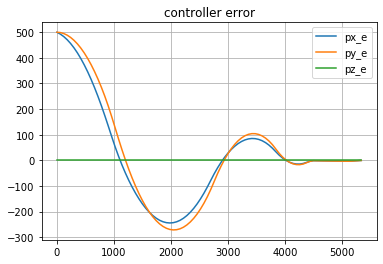

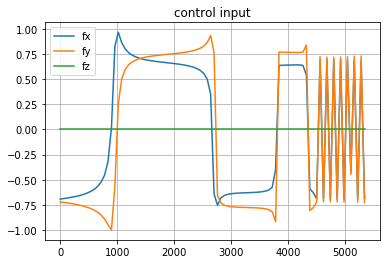

In [15]:
x0 = [500, 500, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0]
dt = 60
tf = dt*60*1.5
data = simulate(x0, dt, tf, eqs)
analyze(eqs, data)
data['xf']
data['g']
print(data['cost'])

creating problem
problem created
solving problem
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1602
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    35781

Total number of variables............................:      270
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      270
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du l

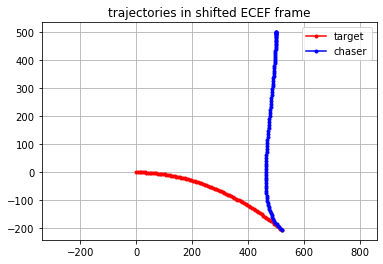

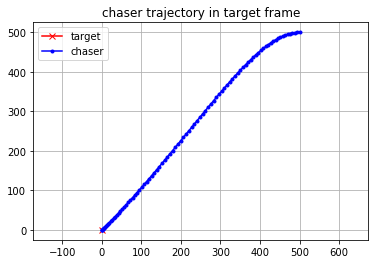

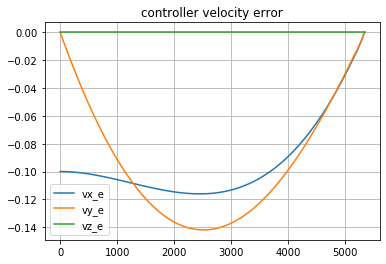

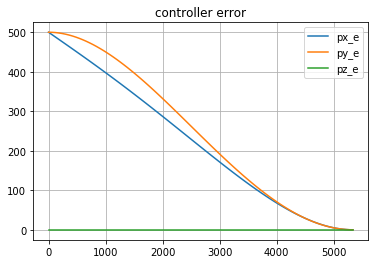

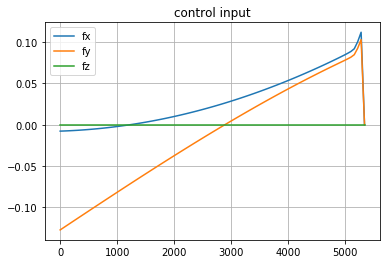

In [16]:
u_opt = fuel_optimal_trajectory(x0, dt, tf)
data_nlmpc = simulate(x0, dt, tf, eqs, u_opt)
analyze(eqs, data_nlmpc)
print(data_nlmpc['cost'])